In [37]:
import numpy as np

First, let me start this with something simple.

Let me consider y = x*2. If I want to compute dy/dx, I know the answer should be 2. But how would an autograd system compute this?

In [38]:
# Value class

class ValueOld:
    def __init__(self, data):
        self.data = data
        self.grad = 0
        self._op = None
        self._inputs = []
    
    def __mul__(self, other):
        if not isinstance(other, ValueOld):
            other = ValueOld(other)
        result = ValueOld(self.data * other.data)
        result._op = 'mul'
        result._inputs = [self, other]
        return result
    
    def backward(self):
        self.grad = 1

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._inputs:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)

        for v in reversed(topo):
            if v._op == 'mul':
                a, b = v._inputs
                a.grad += v.grad * b.data
                b.grad += v.grad * a.data

In [39]:
x = ValueOld(3)
y = x * 2
z = y * 5

In [40]:
z.backward()

In [41]:
print(y.grad)

5


In [42]:
print(x.grad)

10


Time to add all the basic arithmetic operations (addition, subtraction, multiplication, division).

In [128]:
class Value:
    """
    A Value object represents a single scalar value in the computation graph.
    It stores the value itself, its gradient, and the operation that produced it.
    Currently, this class supports arithmetic operations (addition, subtraction, multiplication, division)
    and provides methods for backpropagation.
    """
    def __init__(self, data, _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self.label = label if label else str(data)
        self._op = _op
        self._inputs = []

    def __repr__(self):
        return f"Value.data = {self.data}"

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other, label=str(other))
        result = Value(self.data + other.data, _op='+')
        result._inputs = [self, other]
        return result
    
    def __sub__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        result = Value(self.data - other.data, _op='-')
        result._inputs = [self, other]
        return result
    
    def __neg__(self):
        """
        Since the subtraction method `__sub__` in our Value class is implemented as `self + (-other)`, when we do `a - b`, Python converts it to `a + (-b)`. As a result, the `-b` part triggers the `__neg__` method on `b`. `__neg__` thus converts the value to its negative by multiplying by -1.
        """
        return self * (-1)
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other, label=str(other))
        result = Value(self.data * other.data, _op='*')
        result._inputs = [self, other]
        return result
    
    def __rmul__(self, other):
        """
        This is a special method that allows us to multiply a `Value` object from the right side.
        For example, it lets us write `2 * x` where `x` is a `Value`, instead of just `x * 2`.
        This is part of Python's special method protocol - when Python sees `2 * x`, it first tries to call
        `2.__mul__(x)`, and if that fails (which it will since numbers don't know about our `Value` class),
        it falls back to calling `x.__rmul__(2)`. This is known as the "reflected" or "reversed" multiplication operation.
        """
        return self * other
    
    def __radd__(self, other):
        """
        This is a special method that allows us to add a `Value` object from the right side.
        For example, it lets us write `2 + x` where `x` is a `Value`, instead of just `x + 2`.
        This is part of Python's special method protocol - when Python sees `2 + x`, it first tries to call `2.__add__(x)`, and if that fails (which it will since numbers don't know about our `Value` class), it falls back to calling `x.__radd__(2)`. This is known as the "reflected" or "reversed" addition operation.
        """
        return self + other
    
    def __truediv__(self, other):
        """
        This is a special method that implements division for `Value` objects.
        When Python sees an expression like `a / b` where `a` is a `Value` object,
        it calls this method. This method:
        1. Converts the divisor to a `Value` object if it isn't one already
        2. Creates a new `Value` object containing the quotient of the data values
        3. Records the division operation and input values for use in backpropagation
        
        For example:

        ```python
        x = Value(8)
        y = Value(2)
        z = x / y  # z will be Value(4.0)
        ```
        
        The division operation is important for neural networks as it's used in
        operations like normalization and computing averages. During backpropagation,
        the gradient computation for division follows the quotient rule from calculus.
        """
        if not isinstance(other, Value):
            other = Value(other, label=str(other))
        result = Value(self.data / other.data, _op='/')
        result._inputs = [self, other]
        return result

    def __rtruediv__(self, other):
        """
        This is a special method that allows us to divide a `Value` object from the right side.
        For example, it lets us write `2 / x` where `x` is a `Value`, instead of just `x / 2`.
        This is part of Python's special method protocol - when Python sees `2 / x`, it first tries to call
        `2.__truediv__(x)`, and if that fails (which it will since numbers don't know about our `Value` class),
        it falls back to calling `x.__rtruediv__(2)`. This is known as the "reflected" or "reversed" division operation.
        Note that for division, the order matters - `a/b` is not the same as `b/a`, which is why we flip the operands here.
        """
        if not isinstance(other, Value):
            other = Value(other, label=str(other))
        result = Value(other.data / self.data, _op='/')
        result._inputs = [other, self]
        return result
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._inputs:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)

        self.grad = 1.0

        for v in reversed(topo):            
            if v._op == '+':
                a, b = v._inputs
                a.grad += v.grad * 1 # here v.grad is an upstream gradient, 1 is the local gradient
                b.grad += v.grad * 1

            elif v._op == '-':
                a, b = v._inputs
                a.grad += v.grad * 1 # here v.grad is an upstream gradient, 1 is the local gradient
                b.grad += v.grad * -1

            elif v._op == '*':
                a, b = v._inputs
                a.grad += v.grad * b.data # here v.grad is an upstream gradient, b.data is the local gradient
                b.grad += v.grad * a.data
            
            elif v._op == "/":
                a, b = v._inputs
                a.grad += v.grad * (1/b.data) # here v.grad is an upstream gradient, 1/b.data is the local gradient
                b.grad += v.grad * (-a.data / (b.data)**2)

In [129]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._inputs:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f"{{ {n.label} | data: {n.data:.2f} | grad: {n.grad:.2f} }}", shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [134]:
a = Value(2.0, label='a')
b = a * 3.0; b.label = 'b'
c = a / 3.0; c.label = 'c' 
d = 4*b*c; d.label = 'd'
e = d - a; e.label = 'e'


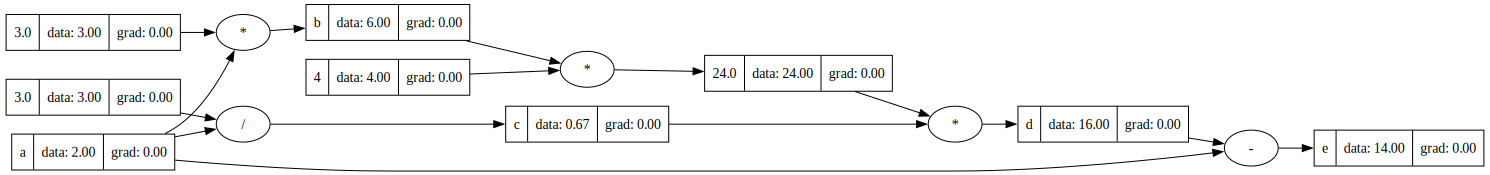

In [135]:
draw_dot(e)

In [132]:
e.backward()